<a href="https://colab.research.google.com/github/LicBoy/datalouna_testTask/blob/main/csgo_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting which team wins for CS:GO games using various data.
## Solved with CatBoost by [*LicBoy*](https://github.com/LicBoy)

## Libraries installation

In [1]:
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!pip install shap
!pip install sklearn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.9 MB 35.7 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.23.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
from google.colab import drive
import os
if not os.path.isdir('/content/gdrive'):
  drive.mount('/content/gdrive')

In [3]:
import catboost
print(catboost.__version__)
!python --version

### On first launch error may appear here.
### Check 'libraries installation' block output and click Restart Runtime here. 

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.1.1
Python 3.8.15


In [4]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *

## Import csv files

In [5]:
csgo_dataset_dir = 'gdrive/MyDrive/csgo_dataset/'

train_df, test_df = pd.read_csv(csgo_dataset_dir + 'train.csv'), pd.read_csv(csgo_dataset_dir + 'test.csv')
players_df = pd.read_csv(csgo_dataset_dir + 'players_feats.csv')

#Just moving 'who_win' column to the beginning of df
column_to_move = train_df.pop("who_win")
train_df.insert(0, "who_win", column_to_move)

In [6]:
# Reconcile dataframes by map_id column
set_train = set(list(train_df['map_id']))
set_players = set(list(players_df['map_id']))
set_test = set(list(test_df['map_id']))

# diff_train = set_players - set_train
# diff_test = set_players - set_test
# print(set_train - set_players, diff_train)
# print(set_test - set_players, diff_test)
# print(set_test - set_train, set_train - set_test)

## Merge train.csv with player_feats.csv by multiple columns and transform player_feats df to multiple dataframes for each team.
### Do the same for test dataframe.

In [7]:
players_train_df = players_df[~players_df['map_id'].isin(set_players - set_train)]
players_test_df = players_df[~players_df['map_id'].isin(set_players - set_test)]
i = 0
for df in [players_train_df, players_test_df]:
  team1_df = df.iloc[::2]
  team1_df.reset_index(drop=True, inplace=True)

  team2_df = df.iloc[1::2] 
  team2_df.reset_index(drop=True, inplace=True)

  team1_df = team1_df.add_prefix('team1_')
  team2_df = team2_df.add_prefix('team2_')

  team1_df.rename(columns = {'team1_team_id' : 'team1_id',
                            'team1_map_id':'map_id',
                            'team1_map_name':'map_name'},
                  inplace = True)
  team2_df.rename(columns = {'team2_team_id' : 'team2_id',
                            'team2_map_id':'map_id',
                            'team2_map_name':'map_name'},
                  inplace = True)
  if i == 0:
    train_df = pd.merge(pd.merge(train_df ,team1_df,how='left', on=['map_id', 'map_name', 'team1_id']),
                     team2_df, how='left', on=['map_id', 'map_name', 'team2_id'])
  else:
    test_df = pd.merge(pd.merge(test_df ,team1_df,how='left', on=['map_id', 'map_name', 'team1_id']),
                     team2_df, how='left', on=['map_id', 'map_name', 'team2_id'])
  i += 1
  # display(merged_df)

## Preparing your data

Label values extraction

In [8]:
y = train_df.who_win

def prepareX(df, train=True, drop_features = []):
  if train:
    df = df.drop('who_win', axis=1)
  for feature in drop_features:
    df = df.drop(feature, axis=1)
  return df

X = prepareX(train_df, drop_features = ['map_id'])

Categorical features declaration

In [9]:
cat_features = ['map_id', 'team1_id', 'team2_id', 'map_name',
                'team1_p1_id', 'team1_p2_id', 'team1_p3_id', 'team1_p4_id', 'team1_p5_id',
                'team2_p1_id', 'team2_p2_id', 'team2_p3_id', 'team2_p4_id', 'team2_p5_id']
cat_features = [feature for feature in cat_features if feature in list(X.columns)]

Looking on label balance in dataset

In [10]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 386, One count = 327


In [11]:
from sklearn.model_selection import train_test_split
#Split data into train and validation datasets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8)

## Build model and fit 

In [12]:
tunned_model = CatBoostClassifier(
    # random_seed=111,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    custom_metric=['Accuracy', 'AUC']
)
tunned_model.fit(
    X, y,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose = 100
)

best_model = CatBoostClassifier(
    # random_seed=111,
    iterations=int(tunned_model.tree_count_ * 1.2),
    custom_metric=['Accuracy', 'AUC']
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=100
)

0:	learn: 0.6902395	test: 0.6898807	best: 0.6898807 (0)	total: 115ms	remaining: 1m 55s
100:	learn: 0.4666071	test: 0.4736058	best: 0.4736058 (100)	total: 3.93s	remaining: 35s
200:	learn: 0.3365539	test: 0.3473226	best: 0.3473226 (200)	total: 10.7s	remaining: 42.5s
300:	learn: 0.2256635	test: 0.2384777	best: 0.2384777 (300)	total: 17.2s	remaining: 39.9s
400:	learn: 0.1471160	test: 0.1572610	best: 0.1572610 (400)	total: 22.8s	remaining: 34.1s
500:	learn: 0.0985598	test: 0.1080281	best: 0.1080281 (500)	total: 29.5s	remaining: 29.3s
600:	learn: 0.0691584	test: 0.0775688	best: 0.0775688 (600)	total: 34.6s	remaining: 23s
700:	learn: 0.0504693	test: 0.0574238	best: 0.0574238 (700)	total: 39.3s	remaining: 16.8s
800:	learn: 0.0379107	test: 0.0432337	best: 0.0432337 (800)	total: 44.1s	remaining: 10.9s
900:	learn: 0.0296612	test: 0.0341527	best: 0.0341527 (900)	total: 48.7s	remaining: 5.35s
999:	learn: 0.0236313	test: 0.0276704	best: 0.0276704 (999)	total: 52s	remaining: 0us

bestTest = 0.0276704

## Build training and validating losses and accuracy 

In [13]:
import matplotlib.pyplot as plt

train_csv = pd.read_csv('catboost_info/learn_error.tsv', sep='\t')
test_csv = pd.read_csv('catboost_info/test_error.tsv', sep='\t')

train_loss, train_acc = list(train_csv.Logloss), list(train_csv.Accuracy)
test_loss, test_acc, test_auc = list(test_csv.Logloss), list(test_csv.Accuracy), list(test_csv.AUC)

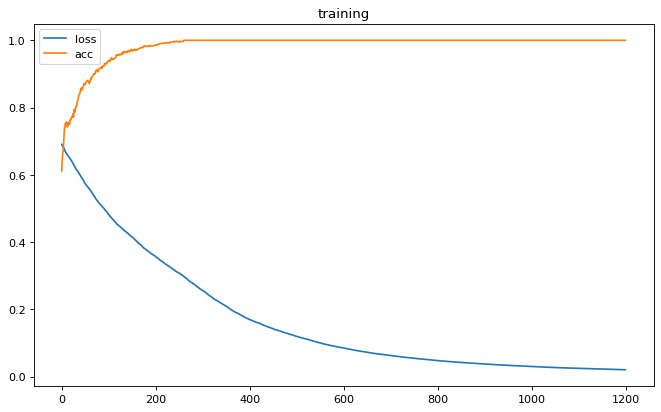

In [14]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(train_loss, label='loss')
plt.plot(train_acc, label='acc')
plt.title('training')
plt.legend()

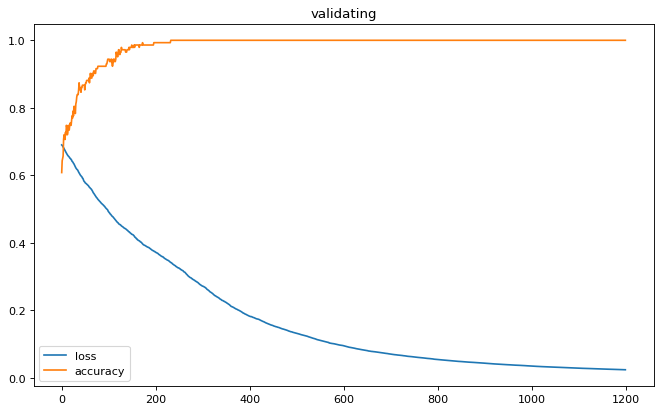

In [15]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(test_loss, label='loss')
plt.plot(test_acc, label='accuracy')
plt.title('validating')
plt.legend()

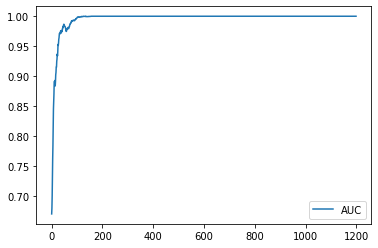

In [16]:
plt.plot(test_auc,label='AUC')
plt.legend()

In [17]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(best_model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

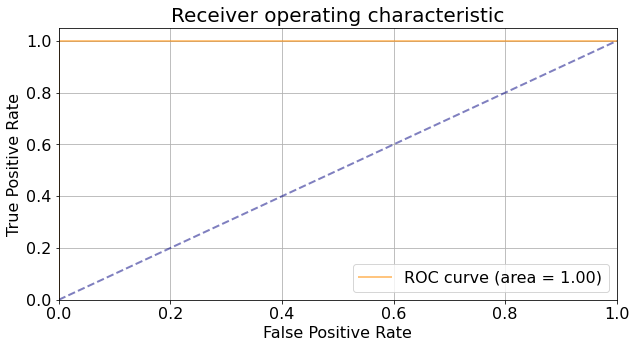

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()


## Feature importances

In [19]:
feature_importance = best_model.get_feature_importance(prettified=True)

In [20]:
important_features = feature_importance[feature_importance.Importances > 0]
important_features

,Feature Id,Importances
0,team2_id,2.536356
1,team2_p3_headshots,2.025659
2,team2_p1_id,1.825497
3,team2_p3_opening_kill_ratio,1.743292
4,team1_p1_id,1.395305
...,...,...
247,team2_p4_maps_played,0.051205
248,team2_p4_saved_teammates_per_round,0.050346
249,team2_p5_id,0.019902
250,team1_p5_id,0.018139


## Shap values (check features impact)

In [21]:
import shap
shap.initjs()

shap_values = best_model.get_feature_importance(Pool(X, label=y, cat_features=cat_features), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(713, 253)


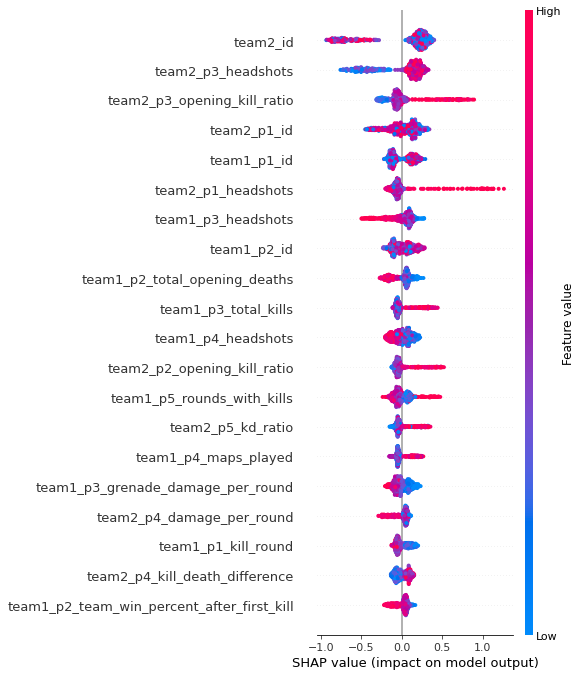

In [22]:
shap.summary_plot(shap_values, X)

## Calculate predictions for the test data


In [23]:
X_test = prepareX(test_df, False, drop_features = ['map_id', 'index'])
test_pool = Pool(data=X_test, cat_features=cat_features)
preds = best_model.predict(test_pool)
print('Predictions:')
print(preds)

Predictions:
[0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1]


In [24]:
saved_df = pd.read_csv(csgo_dataset_dir + 'test.csv')
saved_df['who_win'] = preds
saved_df.to_csv('predictions.csv')
saved_df.head()

,index,map_id,team1_id,team2_id,map_name,who_win
0,713,309,5973,5752,Dust2,0
1,714,541,5973,5752,Vertigo,0
2,715,1,8297,7020,Nuke,1
3,716,392,8297,7020,Mirage,0
4,717,684,8297,7020,Overpass,0
